# Spectrogram preprocessing in different Models & Scenarios

We tried this with a Spectrogram Callback first to extract Preprocessing and Raw Tensors directly from the Pipeline but it was impossible to match the raw Tensors between different models even though `shuffle=False`,`num_workers=1`, `batch_size=1`, and all `augmentations` were off...
So now we do it in an isolated Notebook which makes it easier but Pipeline Preprocessing might not be exactly the same

## Datamodules

### BEANS

In [14]:
from biofoundation.datamodule.beans_datamodule import BEANSDataModule
from birdset.datamodule.base_datamodule import DatasetConfig

def load_beans_dataset(n_classes, sample_rate, name):
    """
    Load the BEANS dataset.
    """
    datasetconfig = DatasetConfig(
        dataset_name=name,
        hf_path=f"DBD-research-group/{name}",
        hf_name="default",
        data_dir="../../../data_birdset",
        n_classes=n_classes,
        sample_rate=sample_rate
    )

    beans_datamodule = BEANSDataModule(dataset=datasetconfig)
    beans_dataset = beans_datamodule._load_data()
    beans_dataset = beans_datamodule._preprocess_data(beans_dataset)
    beans_dataset = beans_datamodule._create_splits(beans_dataset)
    return beans_dataset

### BirdSet

In [15]:
from birdset.datamodule.birdset_datamodule import BirdSetDataModule
from datasets import Audio
from birdset.datamodule.components.event_decoding import EventDecoding

def load_birdset_dataset(sample_rate, name):
    """
    Load the BirdSet dataset.
    """
    # Define the dataset configuration
    datasetconfig = DatasetConfig(
        hf_name=name,
        hf_path="DBD-research-group/BirdSet",
        data_dir="../../../data_birdset",
        sample_rate=sample_rate,
    )

    birdset_datamodule = BirdSetDataModule(dataset=datasetconfig)
    birdset_dataset = birdset_datamodule._load_data()
    birdset_dataset = birdset_datamodule._preprocess_data(birdset_dataset)
    birdset_dataset = birdset_datamodule._create_splits(birdset_dataset)
    #birdset_dataset = birdset_dataset.cast_column("filepath", Audio(sampling_rate=sample_rate))
    return birdset_dataset

In [13]:
dataset = load_birdset_dataset(sample_rate=16000, name="HSN")
decoder = EventDecoding(sample_rate=16000)
#batch = decoder(dataset["test"][0])
single_example = dataset["test"][0]

batch = {
    "filepath": [single_example["filepath"]],
    "detected_events": [single_example.get("detected_events")],
    "start_time": [single_example.get("start_time")],
    "end_time": [single_example.get("end_time")],
}

result = decoder(batch)

LibsndfileError: Error opening '/home/vscode/.cache/huggingface/hub/datasets--DBD-research-group--BirdSet/snapshots/ee31c6ba7dd653e57bf327bdd0c1bde6b0334bba/HSN/extracted/HSN_test5s_shard_0001.tar.gz/HSN_042_20150710_085805_415_420.ogg': System error.

## Load models and loop

In [16]:
import torch
import numpy as np

def convert(inputs, sample_rate=16000, length=10):
    """
    Convert the input to a tensor and 1 batch
    """
    # Get the audio array
    audio = inputs["audio"]["array"]
    target_length = sample_rate * length
    # If audio is longer, cut from the end
    if len(audio) > target_length:
        audio = audio[-target_length:]
    # If audio is shorter, pad at the beginning
    elif len(audio) < target_length:
        pad = target_length - len(audio)
        audio = np.pad(audio, (pad, 0), mode="constant")
    return torch.tensor(audio, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

In [20]:
from biofoundation.modules.models.audiomae import AudioMAEModel
from biofoundation.modules.models.vit_inatsound import Vit_iNatSoundModel
from tqdm import tqdm

models = [(AudioMAEModel, 16000), (Vit_iNatSoundModel, 22_050)]  # (Model, Sample Rate)
beans_datasets = [("beans_dogs", 10)]  # (Dataset Name, Number of Classes)
birdset_datasets = []
num_samples = 3
spectrograms = {}

for model_cls, sample_rate in tqdm(models, desc="Models"):
    model = model_cls(num_classes=None) # num_classes=None as we don't use the classifier here 
    # Load beans datasets
    for beans_name, n_classes in beans_datasets:
        beans_dataset = load_beans_dataset(n_classes=n_classes, sample_rate=sample_rate, name=beans_name)
        for i in range(num_samples):
            input_tensor = convert(beans_dataset["test"][i], sample_rate=sample_rate)
            output = model._preprocess(input_values=input_tensor)
            var_name = f"{model.__class__.__name__}_{beans_name}_{i}"
            spectrograms[var_name] = output
    # Load birdset datasets
    for birdset_name in birdset_datasets:
        birdset_dataset = load_birdset_dataset(sample_rate=sample_rate, name=birdset_name)
        for i in range(num_samples):
            input_tensor = convert(birdset_dataset["test"][i], sample_rate=sample_rate)
            output = model._preprocess(input_values=input_tensor)
            var_name = f"{model.__class__.__name__}_{birdset_name}_{i}"
            spectrograms[var_name] = output

spectrograms

Models:   0%|          | 0/2 [00:00<?, ?it/s]

/home/vscode/.cache/pypoetry/virtualenvs/birdset-xS3fZVNL-py3.10/lib/python3.10/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (257) may be set too low.
  warnings.warn(
Models:  50%|█████     | 1/2 [00:05<00:05,  5.36s/it]

Map:   0%|          | 0/415 [00:00<?, ? examples/s]

/workspace/birdset/datamodule/base_datamodule.py:483: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_one_hot_matrix = torch.tensor(class_one_hot_matrix, dtype=torch.float32)


Map:   0%|          | 0/139 [00:00<?, ? examples/s]

Map:   0%|          | 0/139 [00:00<?, ? examples/s]

Map:   0%|          | 0/83 [00:00<?, ? examples/s]

Models: 100%|██████████| 2/2 [00:20<00:00, 10.05s/it]


{'AudioMAEModel_beans_dogs_0': tensor([[[[-1.0419, -1.0448, -1.0444,  ..., -1.0441, -1.0441, -1.0441],
           [-1.0430, -1.0448, -1.0448,  ..., -1.0448, -1.0448, -1.0448],
           [-1.0429, -1.0448, -1.0447,  ..., -1.0448, -1.0448, -1.0448],
           ...,
           [ 0.4670,  0.4670,  0.4670,  ...,  0.4670,  0.4670,  0.4670],
           [ 0.4670,  0.4670,  0.4670,  ...,  0.4670,  0.4670,  0.4670],
           [ 0.4670,  0.4670,  0.4670,  ...,  0.4670,  0.4670,  0.4670]]]]),
 'AudioMAEModel_beans_dogs_1': tensor([[[[-0.9646, -1.0405, -0.9557,  ..., -0.5073, -0.5986, -0.7204],
           [-1.0411, -1.0447, -1.0416,  ..., -0.5430, -0.6371, -0.8690],
           [-1.0447, -1.0448, -1.0438,  ..., -0.5102, -0.6863, -0.9165],
           ...,
           [ 0.4670,  0.4670,  0.4670,  ...,  0.4670,  0.4670,  0.4670],
           [ 0.4670,  0.4670,  0.4670,  ...,  0.4670,  0.4670,  0.4670],
           [ 0.4670,  0.4670,  0.4670,  ...,  0.4670,  0.4670,  0.4670]]]]),
 'AudioMAEModel_beans_do

TypeError: Invalid shape (3, 224, 224) for image data

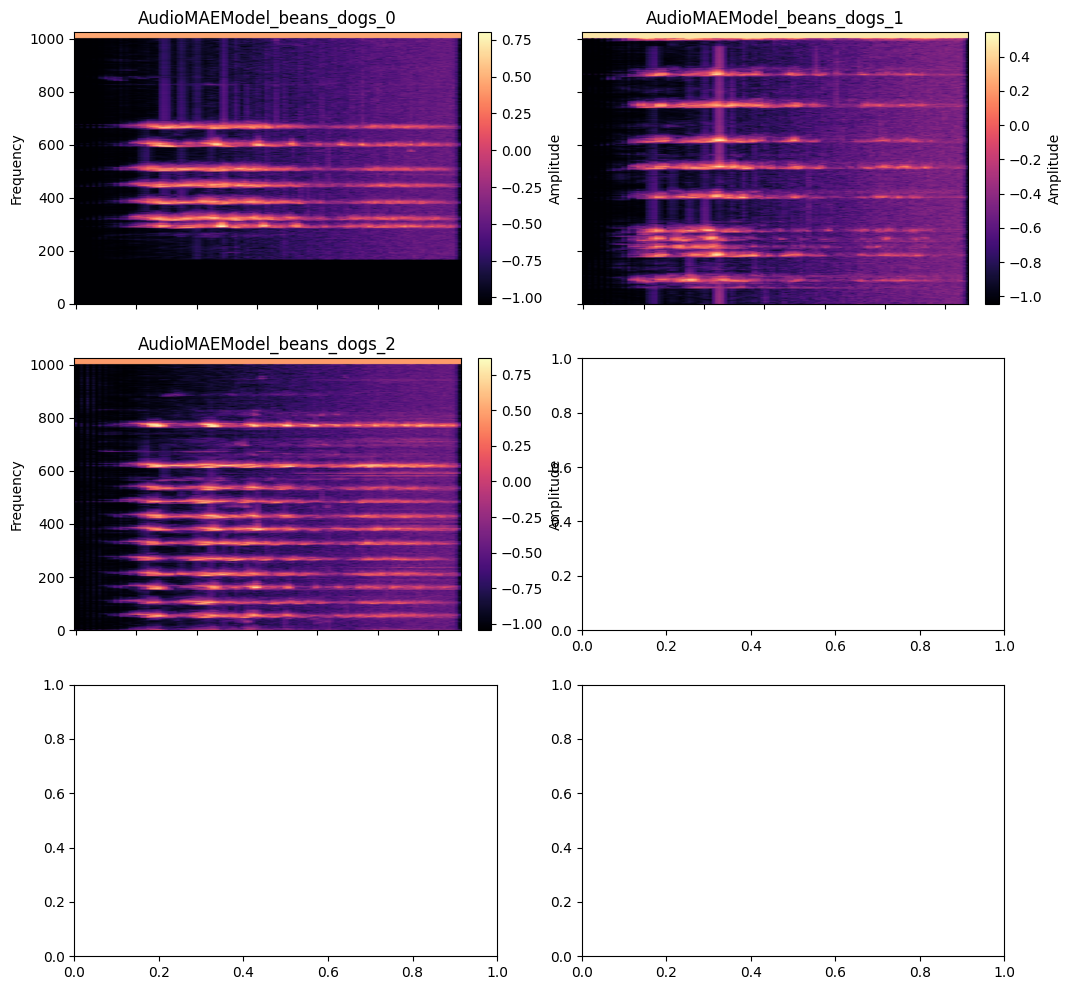

In [22]:
import matplotlib.pyplot as plt

n = len(spectrograms)
cols = 2
rows = (n + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(12, 4 * rows))

for ax, (key, spec) in zip(axes.flat, spectrograms.items()):
    img = spec.squeeze().cpu().numpy()
    im = ax.imshow(img, aspect='auto', origin='lower', cmap='magma')
    ax.set_title(key)
    ax.set_xlabel('Time')
    ax.set_ylabel('Frequency')
    ax.label_outer()
    # Add colorbar for each subplot
    cbar = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
    cbar.set_label('Amplitude')

# Hide any unused subplots
for i in range(n, rows * cols):
    fig.delaxes(axes.flat[i])

plt.tight_layout()
plt.show()